# Import libraries

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3 import PPO, A2C, DDPG


from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

# Download processed data 

In [3]:
processed_full = pd.read_csv('https://raw.githubusercontent.com/TuanAnhlewlew/Deep-Reinforcement-Learning-for-Automated-Stock-trading/main/data/Dow_30_processed.csv')

In [4]:
processed_full.drop(processed_full.columns[0],axis=1,inplace=True)

In [5]:
processed_full

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,ROE,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.778781,7.460152e+08,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.638800,0.101947,0.0
1,2009-01-03,AAPL,3.327500,3.435000,3.311071,2.896057,1.181608e+09,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.665760,0.106249,0.0
2,2009-01-04,AAPL,3.327500,3.435000,3.311071,2.896057,1.181608e+09,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.665760,0.106249,0.0
3,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.896057,1.181608e+09,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.665760,0.106249,0.0
4,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.848290,1.289310e+09,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.654779,0.104497,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131455,2020-12-27,WMT,144.039993,145.300003,143.330002,142.946793,6.448300e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
131456,2020-12-28,WMT,144.039993,145.300003,143.330002,142.946793,6.448300e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
131457,2020-12-29,WMT,145.639999,145.850006,143.589996,142.041199,5.979400e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
131458,2020-12-30,WMT,144.880005,145.149994,143.940002,141.923065,6.250400e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [6]:
train = data_split(processed_full, '2009-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-01-01')
# Check the length of the two datasets
print(len(train))
print(len(trade))

109530
21930


# Create Train environment

In [7]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [8]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [9]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Train

### PPO

#### Scratch

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=500000)

#### Load

In [ ]:
model_ppo=PPO.load('/content/drive/MyDrive/PPO_5e6_continue.zip')
model_ppo.set_env(env_train)

In [ ]:
agent = DRLAgent(env = env_train)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=500000)

In [ ]:
trained_ppo.save('/content/drive/MyDrive/PPO_5e6_continue_continue')

### A2C

#### Scratch

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000)

In [ ]:
trained_a2c.save('/content/drive/MyDrive/A2C')

#### Load

In [ ]:
mo_a2c = A2C.load('/content/drive/MyDrive/A2C_5e5',env=env_train)

In [ ]:
mo_a2c_continue = mo_a2c.learn(total_timesteps=500000,tb_log_name='logs')

In [ ]:
mo_a2c_continue.save('/content/drive/MyDrive/A2C')

### DDPG

#### Scratch

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='tensorboard_log',
                             total_timesteps=10000)

In [ ]:
trained_ppo.save('/content/drive/MyDrive/DDPG')

#### Load

In [ ]:
mo_ddpg = DDPG.load('/content/drive/MyDrive/DDPG',env=env_train)

In [ ]:
mo_ddpg = mo_ddpg.learn(total_timesteps=120000)

In [ ]:
mo_ddpg.save('/content/drive/MyDrive/DDPG')

# Trade

### Create Trade environment

In [10]:
#create trade environment
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

### Dow Jones Industrial Average (DJIA) Baseline stats

In [11]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2019-01-01',
        end = '2021-01-01')

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


### Random trade

In [28]:
def Random_prediction(environment):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            # action, _states = model.predict(test_obs)

            action = test_env.action_space.sample()
            test_obs, rewards, dones, info = test_env.step([action])
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

In [38]:
df_account_value, df_actions = Random_prediction(environment = e_trade_gym)

hit end!


In [39]:
perf_stats_all = backtest_stats(account_value=df_account_value)

Annual return          0.060755
Cumulative returns     0.186601
Annual volatility      0.211563
Sharpe ratio           0.385705
Calmar ratio           0.167321
Stability              0.001049
Max drawdown          -0.363107
Omega ratio            1.104516
Sortino ratio          0.524482
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.829663
Daily value at risk   -0.026331
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,6.076%
Cumulative returns,18.66%
Annual volatility,21.156%
Sharpe ratio,0.39
Calmar ratio,0.17
Stability,0.00
Max drawdown,-36.311%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.31,2020-01-17,2020-03-23,2020-12-08,233
1,7.96,2019-04-26,2019-05-31,2019-07-03,49
2,7.37,2019-07-27,2019-10-02,2019-11-15,80
3,4.33,2019-03-01,2019-03-22,2019-04-26,41
4,2.03,2020-12-08,2020-12-14,2020-12-31,18


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


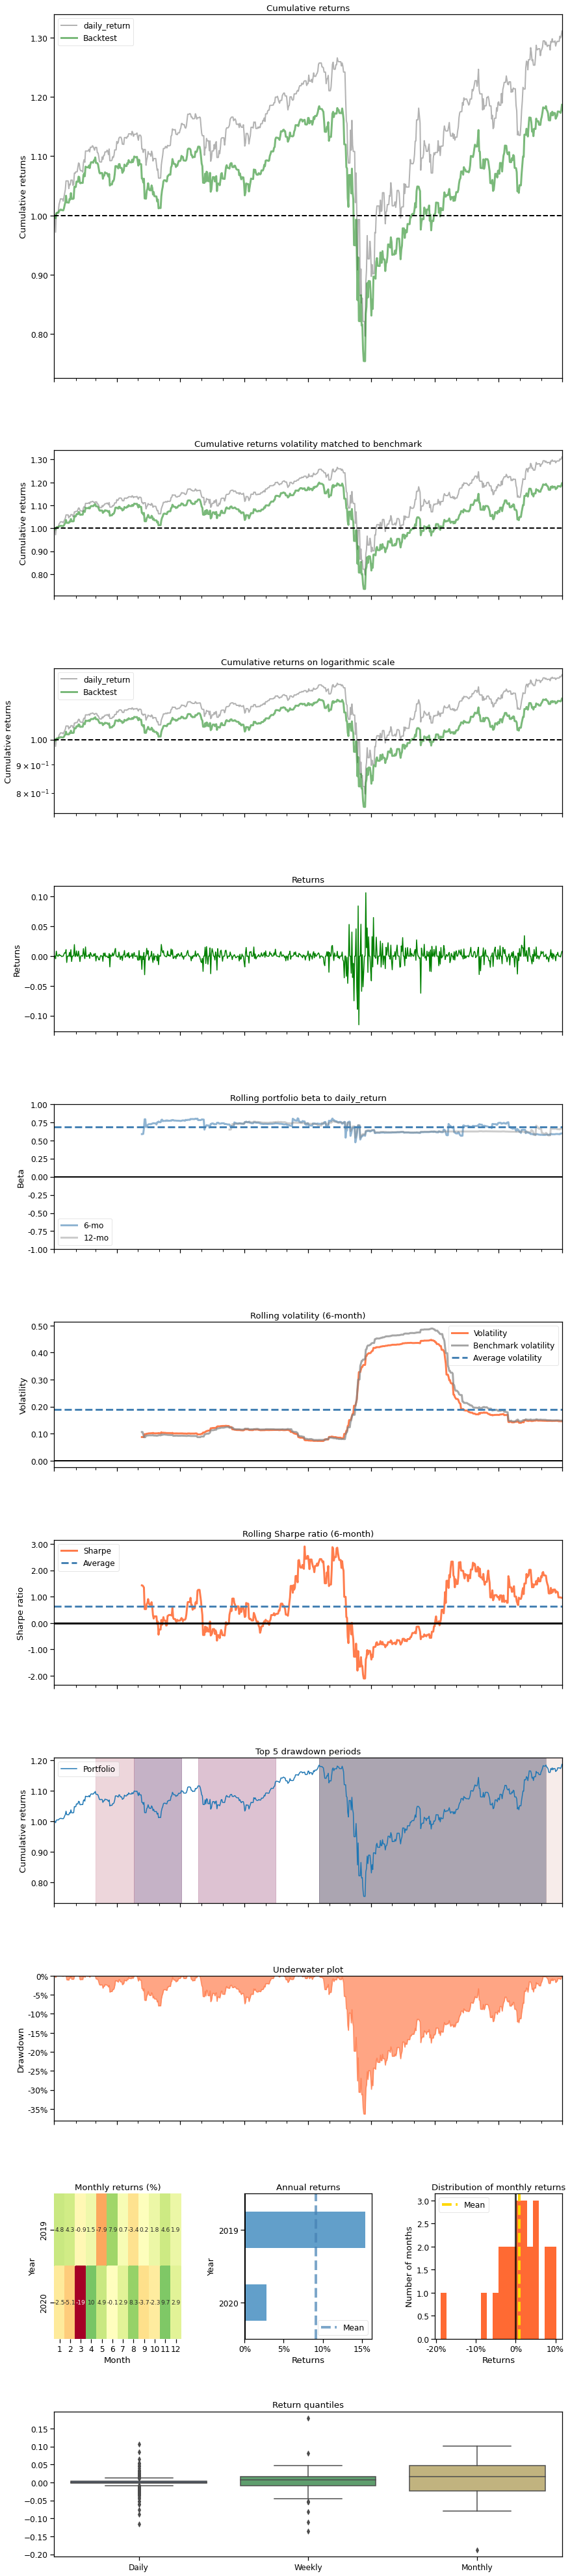

In [40]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

### A2C

In [ ]:
mo = PPO.load('/content/drive/MyDrive/A2C.zip')

In [ ]:
_ = e_trade_gym.reset()

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=mo, 
    environment = e_trade_gym)

hit end!


In [ ]:
perf_stats_all = backtest_stats(account_value=df_account_value)

Annual return          0.138181
Cumulative returns     0.455650
Annual volatility      0.190227
Sharpe ratio           0.776299
Calmar ratio           0.747927
Stability              0.797081
Max drawdown          -0.184751
Omega ratio            1.215352
Sortino ratio          1.164008
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.003219
Daily value at risk   -0.023380
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,13.818%
Cumulative returns,45.565%
Annual volatility,19.023%
Sharpe ratio,0.78
Calmar ratio,0.75
Stability,0.80
Max drawdown,-18.475%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.48,2020-02-15,2020-03-16,2020-07-07,102
1,8.52,2020-09-02,2020-09-23,2020-11-13,53
2,8.32,2019-04-23,2019-06-02,2019-06-22,44
3,6.66,2019-07-13,2019-08-03,2019-09-12,44
4,3.94,2020-07-22,2020-07-31,2020-08-15,18


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


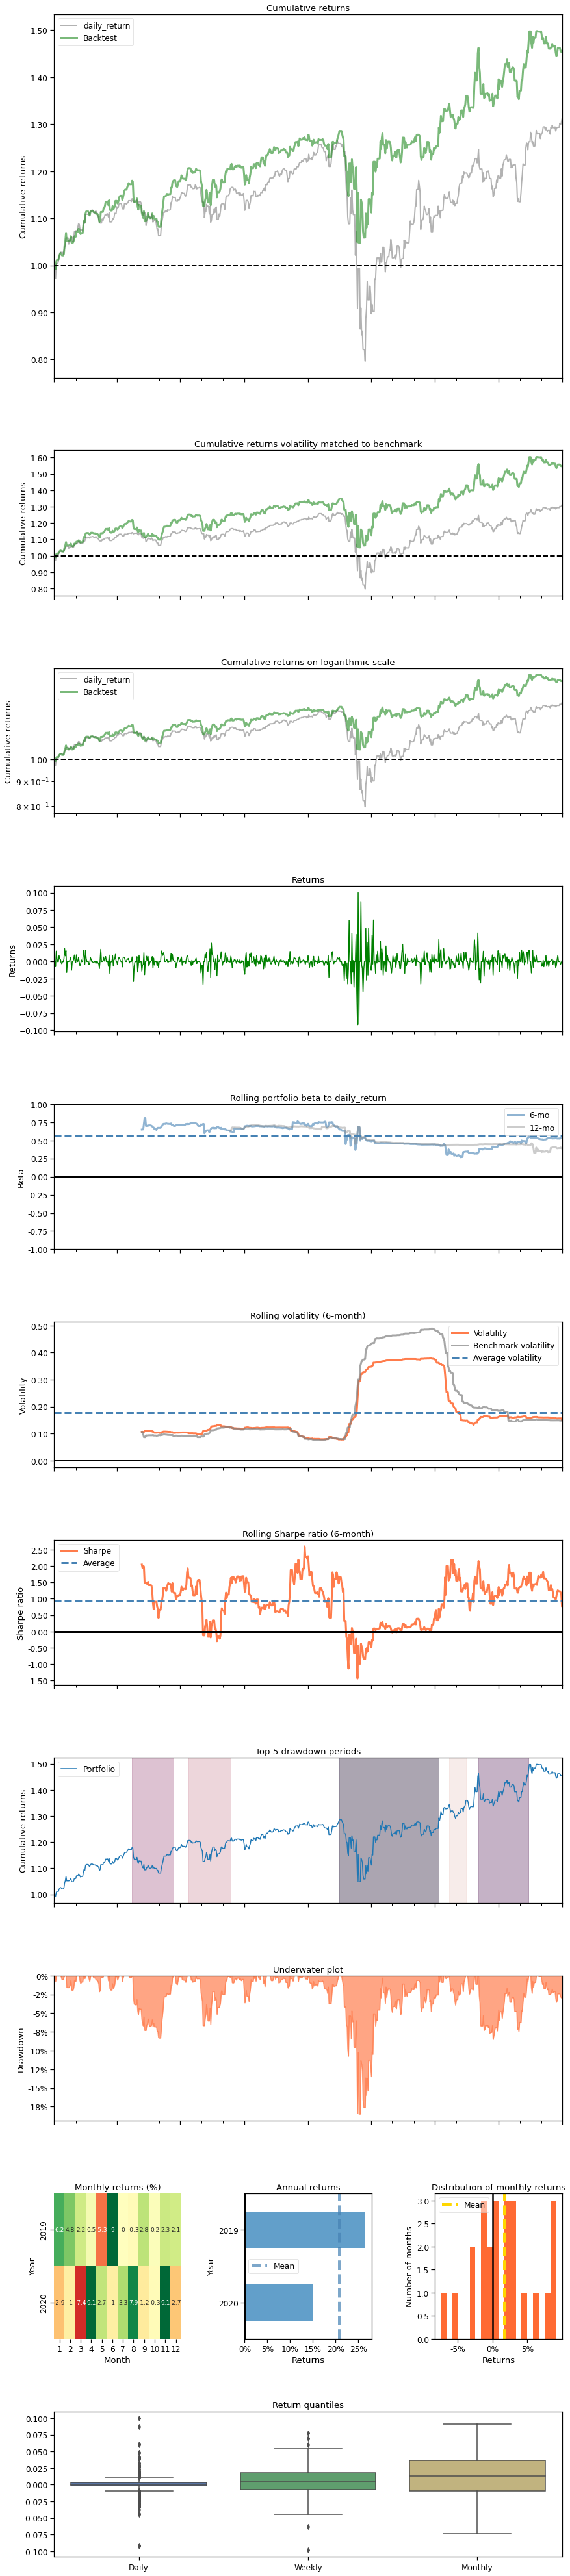

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

### DDPG

In [ ]:
mo = DDPG.load('/content/drive/MyDrive/DDPG.zip')

In [ ]:
_ = e_trade_gym.reset()

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=mo, 
    environment = e_trade_gym)

hit end!


In [ ]:
perf_stats_all = backtest_stats(account_value=df_account_value)

Annual return          0.124189
Cumulative returns     0.404345
Annual volatility      0.226965
Sharpe ratio           0.630881
Calmar ratio           0.364120
Stability              0.460387
Max drawdown          -0.341064
Omega ratio            1.181609
Sortino ratio          0.876642
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.938066
Daily value at risk   -0.028027
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,12.419%
Cumulative returns,40.435%
Annual volatility,22.696%
Sharpe ratio,0.63
Calmar ratio,0.36
Stability,0.46
Max drawdown,-34.106%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.11,2020-01-17,2020-03-21,2020-08-26,159
1,7.99,2020-10-12,2020-10-30,2020-11-07,20
2,7.31,2020-09-02,2020-09-23,2020-10-10,28
3,6.61,2019-04-23,2019-05-31,2019-06-20,43
4,6.05,2019-07-15,2019-08-23,2019-10-30,78


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


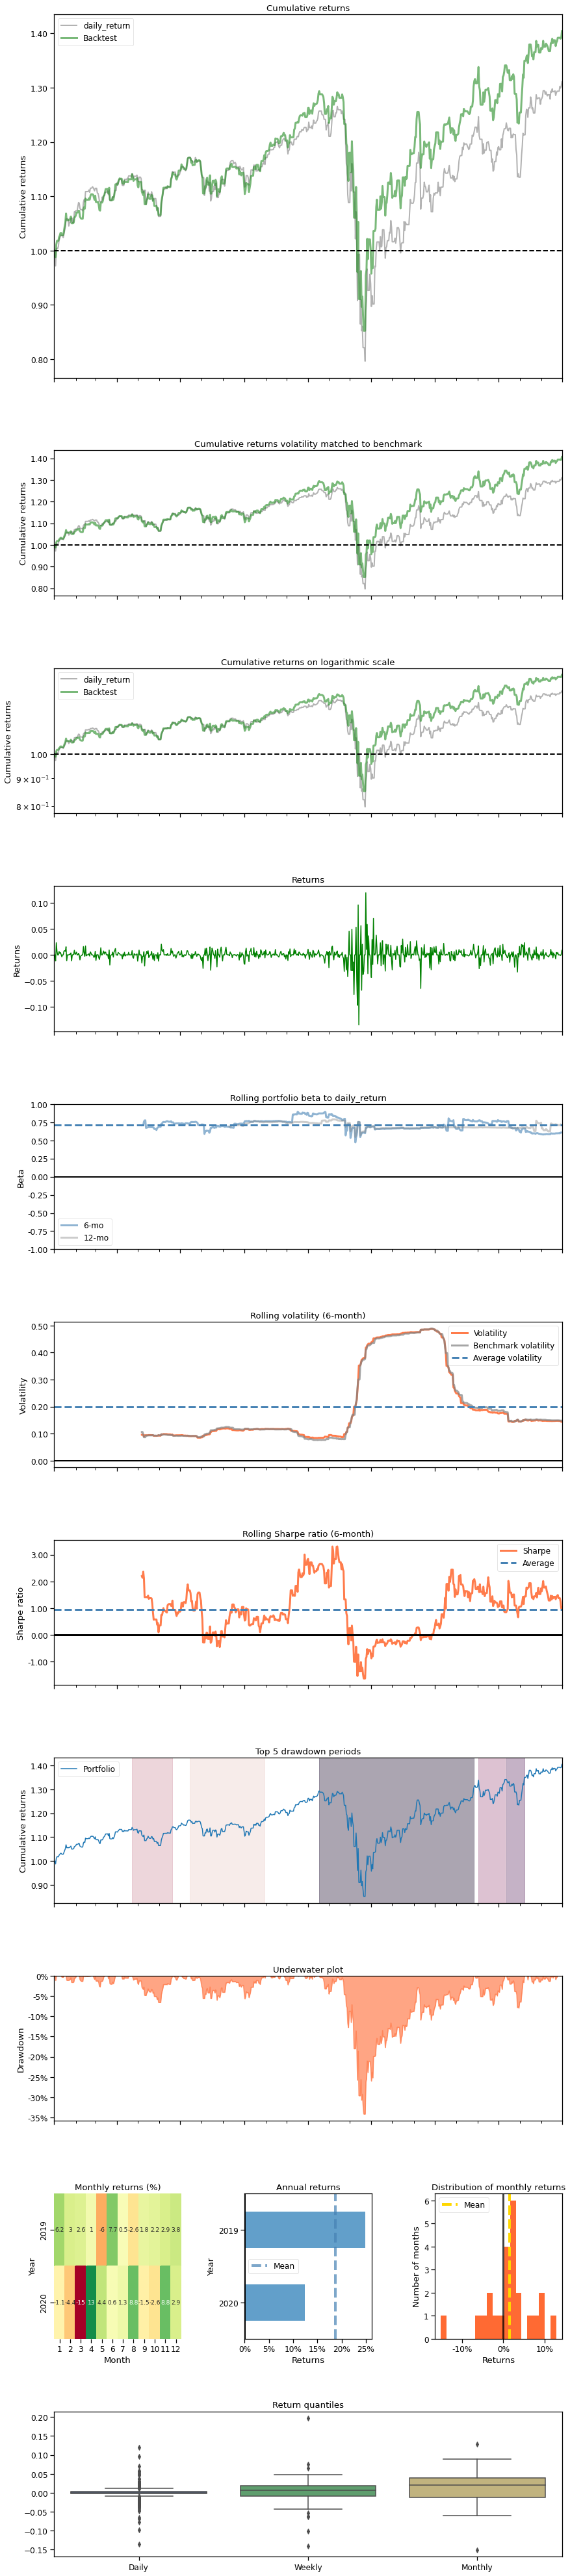

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

### PPO

In [ ]:
mo = PPO.load('/content/drive/MyDrive/PPO.zip')

In [ ]:
_ = e_trade_gym.reset()

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=mo, 
    environment = e_trade_gym)

hit end!


In [ ]:
perf_stats_all = backtest_stats(account_value=df_account_value)

Annual return          0.204615
Cumulative returns     0.716028
Annual volatility      0.242279
Sharpe ratio           0.891212
Calmar ratio           0.718903
Stability              0.877852
Max drawdown          -0.284622
Omega ratio            1.248904
Sortino ratio          1.275771
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.884891
Daily value at risk   -0.029667
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,20.462%
Cumulative returns,71.603%
Annual volatility,24.228%
Sharpe ratio,0.89
Calmar ratio,0.72
Stability,0.88
Max drawdown,-28.462%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.46,2020-02-19,2020-03-23,2020-06-05,78
1,12.62,2020-09-02,2020-10-30,NaT,NaN
2,6.84,2019-07-24,2019-08-23,2019-10-26,68
3,6.54,2019-04-30,2019-06-03,2019-06-08,29
4,5.71,2020-06-10,2020-06-11,2020-07-02,17


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


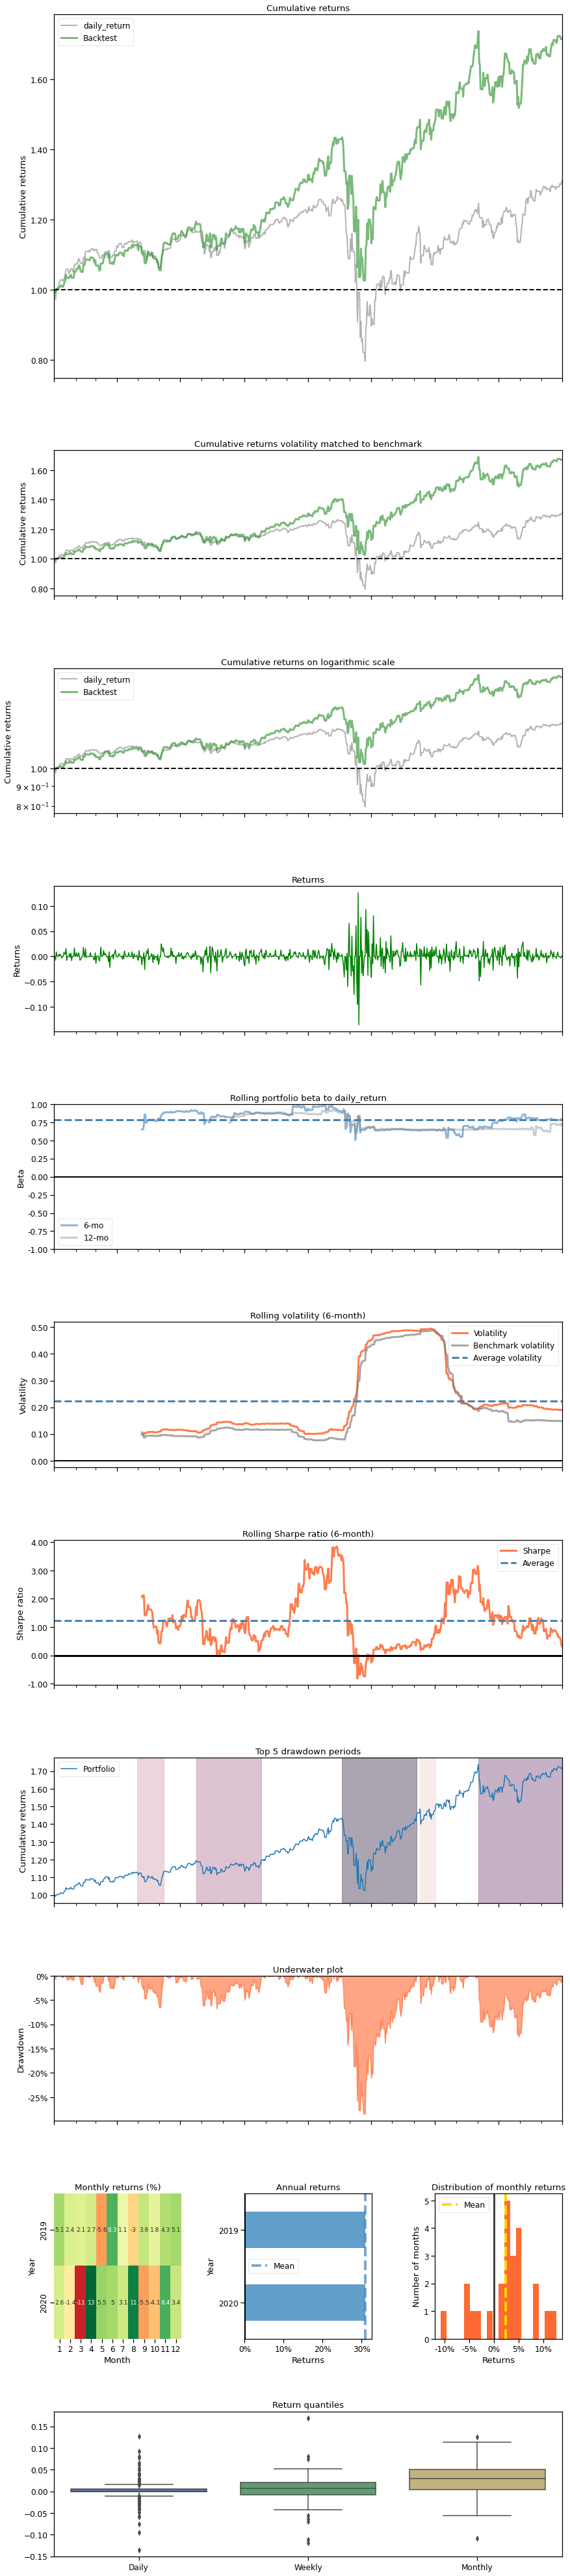

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')